In [2]:
import sys
sys.path.append('/scratch/cloned_repositories/keras-unet/')

import keras_unet

import glob
import imageio
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [3]:
random_seed = 69

In [4]:
weights_dir = '/scratch/single_cell/EPFL/weights'

In [5]:
image_filenames = glob.glob("/scratch/single_cell/EPFL/raw/*.png")
label_filenames = glob.glob("/scratch/single_cell/EPFL/labels/data*.png")

image_filenames.sort()
label_filenames.sort()

In [6]:
images = []
labels = []

for image_filename, label_filename in zip(image_filenames, label_filenames):
    image = imageio.imread(image_filename)
    images.append(image)
    
    label = imageio.imread(label_filename)
    labels.append(label)

images = np.array(images, dtype=np.float32) / 255.
labels = np.array(labels, dtype=np.float32) / 255.

images = np.expand_dims(images, axis=-1)
labels = np.expand_dims(labels, axis=-1)

print(images.min(), images.max(), "    ", labels.min(), labels.max())
print(images.shape, "    ", labels.shape)

0.007843138 1.0      0.003921569 1.0
(165, 768, 1024, 1)      (165, 768, 1024, 1)


In [22]:
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.15, random_state=random_seed)
# x_train = images[: 83]
# y_train = labels[: 83]

# x_val = images[83: ]
# y_val = labels[83: ]

In [23]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (140, 768, 1024, 1)
y_train:  (140, 768, 1024, 1)
x_val:  (25, 768, 1024, 1)
y_val:  (25, 768, 1024, 1)


In [24]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    x_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=15.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=50,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

In [25]:
from keras_unet.models import custom_unet

input_shape = x_train[0].shape

model = custom_unet(
    input_shape,
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid'
)

In [26]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 768, 1024, 1 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 768, 1024, 64 640         input_3[0][0]                    
__________________________________________________________________________________________________
spatial_dropout2d_10 (SpatialDr (None, 768, 1024, 64 0           conv2d_38[0][0]                  
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 768, 1024, 64 36928       spatial_dropout2d_10[0][0]       
____________________________________________________________________________________________

In [35]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_version = 'custom_unet_v0.0.0.1'
# model_filename = 'custom_unet_v0.h5'
callback_checkpoint = ModelCheckpoint(
    weights_dir + '/weights' + model_version + '/weights.{epoch:02d}-{val_loss:.2f}.h5', 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=False,
)

In [36]:
from tensorflow.keras.optimizers import Adam, SGD
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

model.compile(
    #optimizer=Adam(), 
    optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    #loss=jaccard_distance,
    metrics=[iou, iou_thresholded]
)

In [30]:
# don't do this now, because the train - val tests are not split as they were on custom_unet_v0
# model_filename_previous = 'custom_unet_v0'
# model.load_weights(weights_dir + '/' + model_filename_previous + '.h5')

In [37]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=x_train.shape[0],
    epochs=15,    
    validation_data=(x_val, y_val),
    callbacks=[callback_checkpoint]
)

  ...
    to  
  ['...']
Train for 140 steps, validate on 25 samples
Epoch 1/15
139/140 [============================>.] - ETA: 19s - loss: 0.1527 - iou: 0.9046 - iou_thresholded: 0.9464
Epoch 00001: saving model to /scratch/single_cell/EPFL/weights/weightscustom_unet_v0.0.0.1/weights.01-0.15.h5
140/140 [==============================] - 2758s 20s/step - loss: 0.1526 - iou: 0.9046 - iou_thresholded: 0.9463 - val_loss: 0.1546 - val_iou: 0.9235 - val_iou_thresholded: 0.9483
Epoch 2/15
139/140 [============================>.] - ETA: 19s - loss: 0.1217 - iou: 0.9172 - iou_thresholded: 0.9481
Epoch 00002: saving model to /scratch/single_cell/EPFL/weights/weightscustom_unet_v0.0.0.1/weights.02-0.12.h5
140/140 [==============================] - 2763s 20s/step - loss: 0.1218 - iou: 0.9171 - iou_thresholded: 0.9481 - val_loss: 0.1246 - val_iou: 0.9117 - val_iou_thresholded: 0.9475
Epoch 3/15
139/140 [============================>.] - ETA: 19s - loss: 0.1079 - iou: 0.9216 - iou_thresholded: 0.94

In [39]:
model.save(weights_dir + '/' + model_version + '.h5')

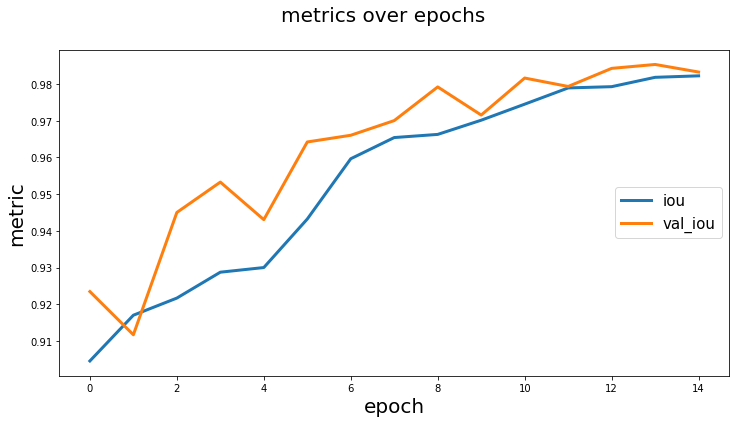

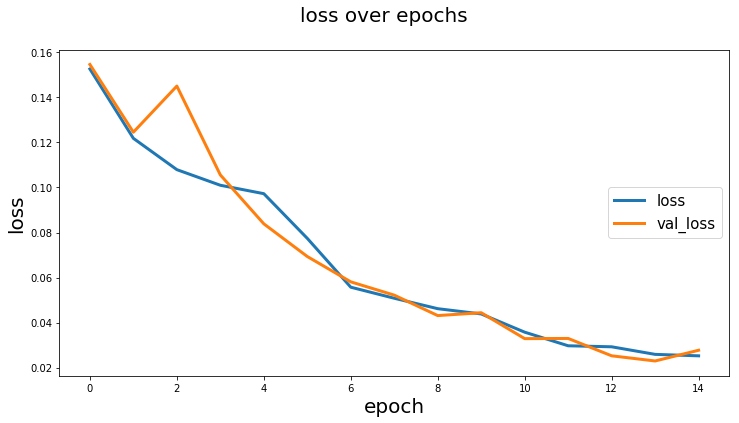

In [40]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [14]:
x_val[0:3].shape

(3, 768, 1024, 1)

In [41]:
# model.load_weights(weights_dir + '/' + model_filename)
y_pred = model.predict(x_val[0:3])

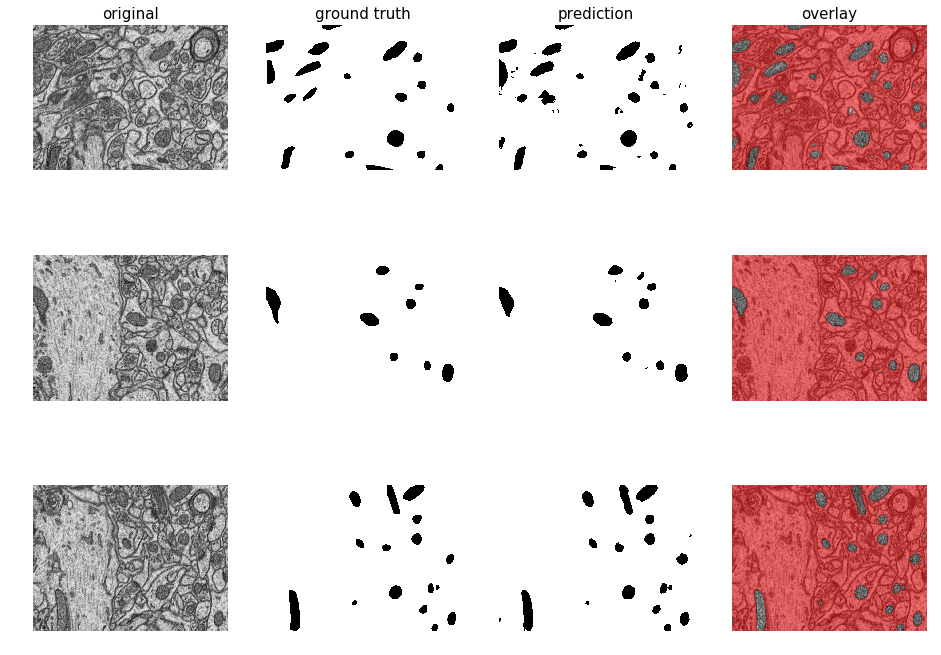

In [42]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=x_val, mask_imgs=y_val, pred_imgs=np.round(y_pred), nm_img_to_plot=3)